<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/acc/3.ML_classifier_averaging_3_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification (with class labels)
***

# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install vecstack==0.4.0 -q
!pip install pyotp --q
!pip install smartapi-python==1.4.1 --q
!pip install logzero --q

  Preparing metadata (setup.py) ... done


In [3]:
#!pip install pandas-ta -q
#==0.2.45b

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from xgboost import XGBClassifier
from vecstack import stacking
import duckdb
import numpy as np
import pandas as pd
#import pandas_ta as ta
from pandas_datareader import data as pdr
START = "2019-01-01"  #yyyy-mm-dd
END = '2024-09-30' #2022-05-13 #2022-05-02
START_testing='2024-10-20'

In [6]:
# package import statement
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
import time
import os
import urllib
import json
import pandas as pd
import datetime as dt

api_key = 'xOHnB7MG'
username = 'M55123447'
pwd = '1471'
smartApi = SmartConnect(api_key)
try:
    token = "GJZACUQI2TTAIBHBA34XNFJURQ"
    totp = pyotp.TOTP(token).now()
except Exception as e:
    logger.error("Invalid Token: The provided token is not valid.")
    raise e

correlation_id = "abcde"
data = smartApi.generateSession(username, pwd, totp)

if data['status'] == False:
    logger.error(data)

else:
    # login api call
    # logger.info(f"You Credentials: {data}")
    authToken = data['data']['jwtToken']
    refreshToken = data['data']['refreshToken']
    # fetch the feedtoken
    feedToken = smartApi.getfeedToken()
    # fetch User Profile
    res = smartApi.getProfile(refreshToken)
    smartApi.generateToken(refreshToken)
    res=res['data']['exchanges']


In [7]:
#Download Nifty50 Index Data
params = {
           "exchange": "NSE",
           "symboltoken": '99926000',
           "interval": "ONE_DAY",
           "fromdate": (dt.datetime(2019, 3, 7).strftime('%Y-%m-%d %H:%M')),
           "todate": (dt.datetime.today().strftime('%Y-%m-%d %H:%M'))
         }
nifty_data = smartApi.getCandleData(params)
nifty_data_format= pd.DataFrame(nifty_data["data"],
                               columns = ["Date","Open","High","Low","Close","Volume"])
nifty_data_format.set_index("Date",inplace=True)
nifty_data_format.index = pd.to_datetime(nifty_data_format.index)
nifty_data_format.index = nifty_data_format.index.tz_localize(None)

In [8]:
nifty_data_format.head(2)

,Open,High,Low,Close,Volume
Date,,,,,
2020-07-20,10999.45,11037.90,10953.00,11022.20,0
2020-07-21,11126.10,11179.55,11113.25,11162.25,0


In [9]:
'''
# Path to your DuckDB database file
db_path = "nifty50_data.duckdb"

# Connect to DuckDB
con = duckdb.connect(db_path)

# Fetch table names
tables = con.execute("SHOW TABLES").fetchdf()

if tables.empty:
    print("No tables found in the database.")
else:
    # Get the first table name
    first_table = tables.iloc[0, 0]
    print(f"Using table: {first_table}")

    # Fetch the table data into a Pandas DataFrame
    df = con.execute(f"SELECT * FROM {first_table}").fetchdf()

    # Save DataFrame to a CSV file
    csv_path = "nifty50_data.csv"
    df.to_csv(csv_path, index=False)

    print(f"Table '{first_table}' exported to {csv_path}")

# Close connection
con.close()
'''

'\n# Path to your DuckDB database file\ndb_path = "nifty50_data.duckdb"\n\n# Connect to DuckDB\ncon = duckdb.connect(db_path)\n\n# Fetch table names\ntables = con.execute("SHOW TABLES").fetchdf()\n\nif tables.empty:\n    print("No tables found in the database.")\nelse:\n    # Get the first table name\n    first_table = tables.iloc[0, 0]\n    print(f"Using table: {first_table}")\n\n    # Fetch the table data into a Pandas DataFrame\n    df = con.execute(f"SELECT * FROM {first_table}").fetchdf()\n\n    # Save DataFrame to a CSV file\n    csv_path = "nifty50_data.csv"\n    df.to_csv(csv_path, index=False)\n\n    print(f"Table \'{first_table}\' exported to {csv_path}")\n\n# Close connection\ncon.close()\n'

In [10]:
trend_decider ='percentchange' #'percentchange' #'impulse' # 'sma'#'long' # percentchange
period=3
days_out=3
dictionary_bull={True:1, False:1}#{True:0.75, False:0.5}
dictionary_bear ={True:1,False:1}# {True:3,False:0.5}

In [11]:
def calculate_technical_indicators(df, fast_macd=6, slow_macd=12, signal_macd=4, vortex_length=4, aroon_length=4, rsi_length=4):
    """
    Calculates and appends technical indicators to a DataFrame using only NumPy and Pandas.

    Args:
        df (pd.DataFrame): DataFrame with columns ['High', 'Low', 'Close'].
        fast_macd (int): Fast EMA period for MACD.
        slow_macd (int): Slow EMA period for MACD.
        signal_macd (int): Signal EMA period for MACD.
        vortex_length (int): Period for Vortex Indicator.
        aroon_length (int): Period for Aroon Indicator.
        rsi_length (int): Period for RSI.

    Returns:
        pd.DataFrame: DataFrame with new technical indicators.
    """

    def ema(series, span):
        return series.ewm(span=span, adjust=False).mean()

    def calc_macd(close, fast, slow, signal):
        macd_line = ema(close, fast) - ema(close, slow)
        signal_line = ema(macd_line, signal)
        hist = macd_line - signal_line
        return macd_line, signal_line, hist

    def calc_vortex(high, low, close, length):
        tr = pd.concat([
            high - low,
            (high - close.shift(1)).abs(),
            (low - close.shift(1)).abs()
        ], axis=1).max(axis=1)

        vm_plus = (high - low.shift(1)).abs()
        vm_minus = (low - high.shift(1)).abs()

        tr_sum = tr.rolling(length).sum()
        vm_plus_sum = vm_plus.rolling(length).sum()
        vm_minus_sum = vm_minus.rolling(length).sum()

        vi_plus = vm_plus_sum / tr_sum
        vi_minus = vm_minus_sum / tr_sum

        return vi_plus, vi_minus

    def calc_aroon(high, low, length):
        aroon_up = 100 * high.rolling(length + 1).apply(lambda x: (length - x.argmax()) / length, raw=True)
        aroon_down = 100 * low.rolling(length + 1).apply(lambda x: (length - x.argmin()) / length, raw=True)
        return aroon_up, aroon_down

    def calc_rsi(close, length):
        delta = close.diff()

        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)

        avg_gain = gain.rolling(length).mean()
        avg_loss = loss.rolling(length).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi


    for t in [1.0, 0.75, 0.5, 0.25]:
        f_macd = max(1, int(fast_macd * t))
        s_macd = max(1, int(slow_macd * t))
        sig_macd = max(1, int(signal_macd * t))
        v_len = max(1, int(vortex_length * t))
        a_len = max(1, int(aroon_length * t))
        r_len = max(1, int(rsi_length * t))

        # MACD
        macd_line, signal_line, hist = calc_macd(df['Close'], f_macd, s_macd, sig_macd)
        df[f'MACD_{f_macd}_{s_macd}_{sig_macd}'] = macd_line
        df[f'MACD_signal_{f_macd}_{s_macd}_{sig_macd}'] = signal_line
        df[f'MACD_hist_{f_macd}_{s_macd}_{sig_macd}'] = hist

        # Vortex
        vi_plus, vi_minus = calc_vortex(df['High'], df['Low'], df['Close'], v_len)
        df[f'VI+_{v_len}'] = vi_plus
        df[f'VI-_{v_len}'] = vi_minus

        # Aroon
        aroon_up, aroon_down = calc_aroon(df['High'], df['Low'], a_len)
        df[f'Aroon_Up_{a_len}'] = aroon_up
        df[f'Aroon_Down_{a_len}'] = aroon_down

        # RSI
        rsi = calc_rsi(df['Close'], r_len)
        df[f'RSI_{r_len}'] = rsi

    return df


In [12]:
def calculate_recent_price_action_features(df):
    """
    Calculate recent price action features for a given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame with 'Date' as index and 'Close', 'Open', 'High', 'Low' columns

    Returns:
    pd.DataFrame: DataFrame with additional columns for recent price action features
    """

    # Ensure the DataFrame is sorted by date
    df = df.sort_index()

    # 1. Previous day's return
    df['prev_day_return'] = df['Close'].pct_change()

    # 2. Weekly return (5 trading days)
    df['weekly_return'] = df['Close'].pct_change(periods=5)

    # 3. Monthly return (21 trading days)
    df['monthly_return'] = df['Close'].pct_change(periods=21)

    # 4. Price momentum (3-day, 5-day, 10-day)
    for period in [2,3,4,5,7,10]:
        df[f'momentum_{period}d'] = df['Close'].pct_change(periods=period)

    # 5. Gap
    df['gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)

    # 6. Intraday price range
    df['intraday_range'] = (df['High'] - df['Low']) / df['Close']

    # 7. Distance from moving averages (5-day, 10-day MA)
    for period in [2,3,4,5,10]:
        ma = df['Close'].rolling(window=period).mean()
        df[f'dist_from_ma_{period}d'] = (df['Close'] - ma) / ma

    # 8. Recent highs and lows (5-day window)
    df['near_high_5d'] = df['Close'] >= df['High'].rolling(window=5).max()
    df['near_low_5d'] = df['Close'] <= df['Low'].rolling(window=5).min()
    df['near_high_3d'] = df['Close'] >= df['High'].rolling(window=3).max()
    df['near_low_3d'] = df['Close'] <= df['Low'].rolling(window=3).min()
    df['near_high_2d'] = df['Close'] >= df['High'].rolling(window=2).max()
    df['near_low_2d'] = df['Close'] <= df['Low'].rolling(window=2).min()
    return df

# Prepare data

In [13]:
nifty_data_format = nifty_data_format.drop(columns=["Volume"])


In [14]:
nifty = nifty_data_format.iloc[:-150]  # All data except the last 150 rows
nifty_test = nifty_data_format.iloc[-150:]  # Last 150 rows

In [15]:
nifty.head(2)

,Open,High,Low,Close
Date,,,,
2020-07-20,10999.45,11037.90,10953.00,11022.20
2020-07-21,11126.10,11179.55,11113.25,11162.25


In [16]:
nifty=calculate_technical_indicators(nifty)
nifty=calculate_recent_price_action_features(nifty)

In [17]:
price_data = nifty.copy()

In [18]:
price_data.describe()

,Open,High,Low,Close,MACD_6_12_4,MACD_signal_6_12_4,MACD_hist_6_12_4,VI+_4,VI-_4,Aroon_Up_4,...,momentum_5d,momentum_7d,momentum_10d,gap,intraday_range,dist_from_ma_2d,dist_from_ma_3d,dist_from_ma_4d,dist_from_ma_5d,dist_from_ma_10d
count,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1211.000000,1207.000000,1207.000000,1207.000000,...,1206.000000,1204.000000,1201.000000,1210.000000,1211.000000,1210.000000,1209.000000,1208.000000,1207.000000,1202.000000
mean,18664.419282,18749.308671,18552.725310,18655.198266,33.960088,33.932816,0.027272,1.024757,0.861087,40.700083,...,0.003518,0.004938,0.007069,0.001207,0.010753,0.000331,0.000662,0.000998,0.001331,0.003026
std,3749.818396,3763.212396,3740.464868,3750.431572,112.623143,105.981355,29.528042,0.327350,0.311285,39.848214,...,0.020521,0.024289,0.028512,0.005514,0.005945,0.004617,0.006894,0.008638,0.010061,0.015384
min,10910.400000,11015.300000,10790.200000,10805.550000,-305.639189,-279.440160,-125.919662,0.192168,0.141430,0.000000,...,-0.067817,-0.073882,-0.084830,-0.050036,0.001895,-0.030553,-0.032925,-0.038726,-0.042959,-0.050289
25%,16266.950000,16337.750000,16167.575000,16253.100000,-47.413925,-44.814942,-17.579667,0.781235,0.621417,0.000000,...,-0.008530,-0.009420,-0.011643,-0.001091,0.006892,-0.002023,-0.003161,-0.003940,-0.004370,-0.005771
50%,17967.450000,18061.250000,17861.500000,17956.600000,40.639517,41.056693,0.807782,1.029023,0.863970,25.000000,...,0.004928,0.006677,0.008148,0.001543,0.009403,0.000482,0.001177,0.001650,0.002004,0.004365
75%,22076.775000,22209.175000,21956.000000,22100.750000,119.054542,117.411514,17.847714,1.259561,1.088909,75.000000,...,0.016646,0.019726,0.025960,0.004027,0.013289,0.003123,0.004733,0.006212,0.007739,0.013463
max,26248.250000,26277.350000,26151.400000,26216.050000,318.242884,275.758307,117.048205,2.171603,1.714702,100.000000,...,0.094587,0.108159,0.112119,0.035827,0.086730,0.023163,0.032420,0.039201,0.041089,0.054263


In [19]:
features = price_data.columns.tolist()

In [20]:
features

['Open',
 'High',
 'Low',
 'Close',
 'MACD_6_12_4',
 'MACD_signal_6_12_4',
 'MACD_hist_6_12_4',
 'VI+_4',
 'VI-_4',
 'Aroon_Up_4',
 'Aroon_Down_4',
 'RSI_4',
 'MACD_4_9_3',
 'MACD_signal_4_9_3',
 'MACD_hist_4_9_3',
 'VI+_3',
 'VI-_3',
 'Aroon_Up_3',
 'Aroon_Down_3',
 'RSI_3',
 'MACD_3_6_2',
 'MACD_signal_3_6_2',
 'MACD_hist_3_6_2',
 'VI+_2',
 'VI-_2',
 'Aroon_Up_2',
 'Aroon_Down_2',
 'RSI_2',
 'MACD_1_3_1',
 'MACD_signal_1_3_1',
 'MACD_hist_1_3_1',
 'VI+_1',
 'VI-_1',
 'Aroon_Up_1',
 'Aroon_Down_1',
 'RSI_1',
 'prev_day_return',
 'weekly_return',
 'monthly_return',
 'momentum_2d',
 'momentum_3d',
 'momentum_4d',
 'momentum_5d',
 'momentum_7d',
 'momentum_10d',
 'gap',
 'intraday_range',
 'dist_from_ma_2d',
 'dist_from_ma_3d',
 'dist_from_ma_4d',
 'dist_from_ma_5d',
 'dist_from_ma_10d',
 'near_high_5d',
 'near_low_5d',
 'near_high_3d',
 'near_low_3d',
 'near_high_2d',
 'near_low_2d']

#####df = df.assign(flag=df['apm'].gt(df['apm'].shift()))

In [21]:
if trend_decider=='impulse':
  price_data=price_data.assign(Flag=(price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift())))
elif trend_decider=='sma':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift()))
elif trend_decider=='long':
  price_data= price_data.assign(Flag=price_data['ADV_50'].lt(price_data['ADV_50'].shift(period)))
elif trend_decider=='percentchange':
  close_groups = price_data['Close'].transform(lambda x : np.sign(x.diff(days_out)))
  price_data['Flag'] = close_groups

# Calculate the conditions separately
condition1 = price_data['MACDh_12_26_9'] > price_data['MACDh_12_26_9'].shift()
condition2 = price_data['ADV_13'] > price_data['ADV_13'].shift()

# Create the Strength_Flag_dummy column
price_data['Strength_Flag_dummy'] = condition1 & condition2


In [22]:
#price_data=price_data.assign(Strength_Flag_dummy=(price_data['MACDh_12_26_9'].gt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].gt(price_data['ADV_13'].shift())))

In [23]:
#price_data=price_data.assign(Strength_Flag_dum=(price_data['MACDh_12_26_9'].lt(price_data['MACDh_12_26_9'].shift()) & price_data['ADV_13'].lt(price_data['ADV_13'].shift())))

In [24]:
all_nan_columns = price_data.columns[price_data.isna().all()]
print(all_nan_columns)

Index([], dtype='object')


In [25]:
price_data.dropna(inplace=True)

In [26]:
#price_data.Strength_Flag_dummy.value_counts()

In [27]:
#price_data.Strength_Flag_dummy = price_data.Strength_Flag_dummy.replace(dictionary_bull)

In [28]:
#price_data.Strength_Flag_dum.value_counts()

In [29]:
#price_data.Strength_Flag_dum = price_data.Strength_Flag_dum.replace(dictionary_bear)

In [30]:
#price_data['Strength_Flag']=price_data.Strength_Flag_dum+price_data.Strength_Flag_dummy

In [31]:
X_Cols = price_data[features]
Y_Cols = price_data['Flag']
samp_train= int(len(price_data)*.75) -100
samp_test= samp_train+100
X_train = X_Cols[:samp_train]
X_test = X_Cols[samp_test:]
y_train = Y_Cols[:samp_train]
y_test = Y_Cols[samp_test:]

In [32]:
len(price_data)

1189

# Initialize 1st level models

In [33]:
#sample_w=price_data[:samp_train].Strength_Flag.values

In [34]:
models_L1 = [
    LogisticRegression(max_iter=12000),
    svm.SVC(kernel='linear'),
    ExtraTreesClassifier(random_state=0, n_jobs=-1,
                         n_estimators=100, max_depth=3,class_weight='balanced' ),

    RandomForestClassifier(random_state=0, n_jobs=-1,
                           n_estimators=500, max_depth=3,class_weight='balanced'),

    LDA(solver='svd', shrinkage=None, priors=None, n_components=None,
        store_covariance=False, tol=0.0001, covariance_estimator=None),

]

In [35]:
'''XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,
                  n_estimators=100, max_depth=3)'''

'XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,sample_weight=sample_w,\n                  n_estimators=100, max_depth=3)'

In [36]:
model_L1_0 = models_L1[0]
_ = model_L1_0.fit(X_train, y_train)
# save model in file if you need

model_L1_1 = models_L1[1]
_ = model_L1_1.fit(X_train, y_train)#sample_weight=sample_w
# save model in file if you need

model_L1_2 = models_L1[2]
_ = model_L1_2.fit(X_train, y_train)#,sample_weight=sample_w
# save model in file if you need

model_L1_3 = models_L1[3]
_ = model_L1_3.fit(X_train, y_train)
# save model in file if you need
model_L1_4 = models_L1[4]
_ = model_L1_4.fit(X_train, y_train)
# save model in file if you need

# save model in file if you need



In [37]:
model_L1_3.feature_importances_

array([7.71260700e-05, 8.57320576e-05, 1.31147967e-04, 1.56133056e-04,
       3.37356706e-04, 7.99629808e-05, 1.42596566e-02, 8.05050893e-03,
       2.21430315e-03, 3.40697698e-03, 8.57291890e-03, 2.95925671e-02,
       8.00289556e-04, 4.46263888e-04, 2.19847130e-02, 9.00715363e-02,
       5.32168248e-02, 1.63474342e-02, 2.15818444e-02, 1.77597224e-01,
       4.26875533e-03, 2.05212897e-03, 3.33021022e-03, 2.57044499e-02,
       4.58771686e-02, 6.98014710e-03, 5.46219979e-03, 1.21834868e-02,
       2.98355889e-02, 1.40771182e-02, 0.00000000e+00, 4.48544903e-04,
       5.63098376e-04, 1.84047389e-04, 2.47851287e-05, 2.57829730e-04,
       1.14483641e-03, 2.54457801e-03, 4.90028700e-04, 1.65940767e-02,
       1.70924465e-01, 3.07696192e-02, 2.41391760e-03, 5.50921386e-04,
       7.20526070e-05, 1.65423653e-04, 2.51218420e-04, 1.59503668e-03,
       7.97794355e-03, 7.08734173e-02, 8.70644220e-02, 6.30796364e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [38]:
importances = model_L1_3.feature_importances_
data = {'feature_name': features, 'importance': importances*100}
df = pd.DataFrame(data)

In [39]:
df = df.sort_values(by='importance')
print(df)

          feature_name  importance
30     MACD_hist_1_3_1    0.000000
56        near_high_2d    0.000000
55         near_low_3d    0.000000
54        near_high_3d    0.000000
57         near_low_2d    0.000000
52        near_high_5d    0.000000
53         near_low_5d    0.000000
34        Aroon_Down_1    0.002479
44        momentum_10d    0.007205
0                 Open    0.007713
5   MACD_signal_6_12_4    0.007996
1                 High    0.008573
2                  Low    0.013115
3                Close    0.015613
45                 gap    0.016542
33          Aroon_Up_1    0.018405
46      intraday_range    0.025122
35               RSI_1    0.025783
4          MACD_6_12_4    0.033736
13   MACD_signal_4_9_3    0.044626
31               VI+_1    0.044854
38      monthly_return    0.049003
43         momentum_7d    0.055092
32               VI-_1    0.056310
12          MACD_4_9_3    0.080029
36     prev_day_return    0.114484
47     dist_from_ma_2d    0.159504
21   MACD_signal_3_6

# Perform stacking

In [40]:
S_train, S_test = stacking(models_L1,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=False,           # classification task (if you need
                                                       #     regression - set to True)
                           mode='oof',                 # mode: oof for train set, predict test
                                                       #mode='oof_pred_bag'(for training) and oof for inference
                                                      #     set in each fold and vote
                           needs_proba=False,          # predict class labels (if you need
                                                       #     probabilities - set to True)
                           save_dir=None,              # do not save result and log (to save
                                                       #     in current dir - set to '.')
                           metric=accuracy_score,      # metric: callable
                           n_folds=4,                  # number of folds
                           stratified=True,            # stratified split for folds
                           shuffle=False,               # shuffle the data
                           random_state=None,             # ensure reproducibility
                           verbose=2)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof]
n_models:     [5]

model  0:     [LogisticRegression]
    fold  0:  [0.91919192]
    fold  1:  [0.98484848]
    fold  2:  [0.97979798]
    fold  3:  [0.96446701]
    ----
    MEAN:     [0.96207635] + [0.02587188]
    FULL:     [0.96207332]

model  1:     [SVC]
    fold  0:  [0.94444444]
    fold  1:  [0.95959596]
    fold  2:  [0.96969697]
    fold  3:  [0.97461929]
    ----
    MEAN:     [0.96208917] + [0.01153728]
    FULL:     [0.96207332]

model  2:     [ExtraTreesClassifier]
    fold  0:  [0.95454545]
    fold  1:  [0.95454545]
    fold  2:  [0.91414141]
    fold  3:  [0.90862944]
    ----
    MEAN:     [0.93296544] + [0.02166783]
    FULL:     [0.93299621]

model  3:     [RandomForestClassifier]
    fold  0:  [0.99494949]
    fold  1:  [1.00000000]
    fold  2:  [0.99494949]
    fold  3:  [1.00000000]
    ----
    MEAN:     [0.99747475] + [0.00252525]
    FULL:     [0.99747155]

mo

# Look at the result

So now we have OOF from 1st level models and we can build 2nd level model.  
But first let's look at the result.  
We have three 1st level models, so we expect to get three columns in `S_train` and `S_test`.  

In [41]:
# XGboost
model_L1_X = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 reg_alpha= 0.01,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
# Fit 2nd level model
dummy_train = model_L1_X.fit(X_train,y_train)
# Predict
#y_pred = model_L2.predict(S_test)

# Final prediction score
#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

# Apply 2nd level model

In [42]:
'''
# Initialize 2nd level model
model_L2 = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 reg_alpha= 0.01,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
S_train=np.c_[S_train,dummy_train]
# Fit 2nd level model
_ = model_L2.fit(S_train,y_train)
# Predict
y_pred = model_L2.predict(S_test)

# Final prediction score
#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))
'''

"\n# Initialize 2nd level model\nmodel_L2 = XGBClassifier(learning_rate =0.1,\n n_estimators=100,\n max_depth=3,\n min_child_weight=1,\n gamma=0,\n reg_alpha= 0.01,\n subsample=0.75,\n colsample_bytree=0.75,\n objective= 'binary:logistic',\n nthread=4,\n scale_pos_weight=1,\n seed=27)\nS_train=np.c_[S_train,dummy_train]\n# Fit 2nd level model\n_ = model_L2.fit(S_train,y_train)\n# Predict\ny_pred = model_L2.predict(S_test)\n\n# Final prediction score\n#print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))\n"

# Make Predictions

In [43]:
nifty_test = nifty_test[~nifty_test.index.duplicated(keep='first')]  # Keeps only the first occurrence


In [44]:
nifty_test=calculate_technical_indicators(nifty_test)
nifty_test=calculate_recent_price_action_features(nifty_test)
df = nifty_test.copy()
# I Just need the Close
price_data_new = df.copy()

price_data_new.tail(2)

,Open,High,Low,Close,MACD_6_12_4,MACD_signal_6_12_4,MACD_hist_6_12_4,VI+_4,VI-_4,Aroon_Up_4,...,dist_from_ma_3d,dist_from_ma_4d,dist_from_ma_5d,dist_from_ma_10d,near_high_5d,near_low_5d,near_high_3d,near_low_3d,near_high_2d,near_low_2d
Date,,,,,,,,,,,,,,,,,,,,,
2026-01-06,26189.7,26273.95,26124.75,26178.70,54.745756,50.231765,4.513991,1.251982,0.860864,25.0,...,-0.002812,-0.001805,-0.001070,0.001955,False,False,False,False,False,False
2026-01-07,26143.1,26187.15,26067.90,26114.85,38.364700,45.484939,-7.120239,0.930343,1.015922,50.0,...,-0.002537,-0.003938,-0.003394,-0.000250,False,False,False,False,False,False


In [45]:
# Group by the `Symbol` column, then grab the `Close` column.
#close_groups = price_data_new['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
#close_groups = close_groups.transform(lambda x : np.sign(x.diff(days_out)))

# add the data to the main dataframe.
#price_data_new['Prediction'] = close_groups
price_data_new = price_data_new.dropna()

X_test_new =price_data_new[features]
#Y_Cols = price_data_new['Prediction']




In [46]:
#[4] Then new test set (X_test_new) comes. We load our 1st level models and predict new test set to get stacked features (S_test_new):
y_pred_L1_0 = model_L1_0.predict(X_test_new)
y_pred_L1_1 = model_L1_1.predict(X_test_new)
y_pred_L1_2 = model_L1_2.predict(X_test_new)
y_pred_L1_3 = model_L1_3.predict(X_test_new)
y_pred_L1_4 = model_L1_4.predict(X_test_new)

#y_pred_l1_6= model_L1_X.predict(X_test_new)
S_test_new = np.c_[y_pred_L1_0, y_pred_L1_1,y_pred_L1_2,y_pred_L1_3,y_pred_L1_4]
#[5] Then we load our 2nd level model and predict S_test_new to get final prediction:

#y_pred_new = model_L2.predict(S_test_new)


In [47]:
S_test_new[-5:]#.sum(axis=1)

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1.]])

In [48]:
y_pred_new_p = S_test_new.sum(axis=1)

In [49]:
y_pred_new_p

array([-5., -5., -3.,  5.,  5., -5., -5., -5., -5.,  5.,  3., -5., -5.,
       -5.,  5., -1., -5., -5., -5.,  1.,  5., -5., -5., -5.,  1., -5.,
       -5.,  1., -1.,  5.,  3.,  5.,  5.,  5.,  5., -5., -5., -5., -5.,
       -5., -5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5., -5., -5., -5., -5., -5., -5., -5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5., -5.,  5.,  5.,  5.,  5.,  5.,  5., -5.,
        3.,  5.,  5., -5., -5., -5., -5., -5., -5., -5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5., -5., -5.,  5.,  5.,  5., -3., -5.,
       -5., -5.,  5., -3., -5., -5., -5.,  5.,  5., -5., -5., -5.,  5.,
        5.,  5.,  5., -5., -5., -5.,  5.,  5.,  5.,  5.,  5., -5.])

In [50]:
'''
price_data_new=price_data_new.assign(Strength_Flag_dummy=(price_data_new['MACDh_12_26_9'].gt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].gt(price_data_new['ADV_13'].shift())))
price_data_new=price_data_new.assign(Strength_Flag_dum=(price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift())))
price_data_new.dropna(inplace=True)
price_data_new.Strength_Flag_dum = price_data_new.Strength_Flag_dum.replace(dictionary_bear)
price_data_new.Strength_Flag_dummy = price_data_new.Strength_Flag_dummy.replace(dictionary_bull)
price_data_new['Strength_Flag']=price_data_new.Strength_Flag_dum+price_data_new.Strength_Flag_dummy
'''

"\nprice_data_new=price_data_new.assign(Strength_Flag_dummy=(price_data_new['MACDh_12_26_9'].gt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].gt(price_data_new['ADV_13'].shift())))\nprice_data_new=price_data_new.assign(Strength_Flag_dum=(price_data_new['MACDh_12_26_9'].lt(price_data_new['MACDh_12_26_9'].shift()) & price_data_new['ADV_13'].lt(price_data_new['ADV_13'].shift())))\nprice_data_new.dropna(inplace=True)\nprice_data_new.Strength_Flag_dum = price_data_new.Strength_Flag_dum.replace(dictionary_bear)\nprice_data_new.Strength_Flag_dummy = price_data_new.Strength_Flag_dummy.replace(dictionary_bull)\nprice_data_new['Strength_Flag']=price_data_new.Strength_Flag_dum+price_data_new.Strength_Flag_dummy\n"

In [51]:
#price_data_new.Strength_Flag = price_data_new.Strength_Flag.replace(dictionary)

In [52]:
#price_data_new.tail(2)

In [53]:
'''
if trend_decider !='percentchange':
  #price_data_new.Flag = price_data_new.Flag.replace({True: 0, False: 1})
  y_pred_new=y_pred_new.astype(int)
  indices_one = y_pred_new == 1
  indices_zero = y_pred_new == 0
  y_pred_new[indices_one] = 0 # replacing 1s with 0s
  y_pred_new[indices_zero] = 1 # replacing 0s with 1s
if trend_decider =='percentchange':
  #price_data_new.Flag = np.where(price_data_new.close>price_data_new.close.shift(1),1,-1)
  print('done')
'''

"\nif trend_decider !='percentchange':\n  #price_data_new.Flag = price_data_new.Flag.replace({True: 0, False: 1})\n  y_pred_new=y_pred_new.astype(int)\n  indices_one = y_pred_new == 1\n  indices_zero = y_pred_new == 0\n  y_pred_new[indices_one] = 0 # replacing 1s with 0s\n  y_pred_new[indices_zero] = 1 # replacing 0s with 1s\nif trend_decider =='percentchange':\n  #price_data_new.Flag = np.where(price_data_new.close>price_data_new.close.shift(1),1,-1)\n  print('done')\n"

In [54]:
#actuals=price_data_new['Flag'].dropna()
#actuals.value_counts()

rapida = 18
lenta = 26
stdv = 0.5
df['fast'] =df['Close'].ewm(span=rapida).mean()
df['slow'] =df['Close'].ewm(span=lenta).mean()
df['bband']= df['fast']-df['slow']
df['avg'] = df['bband'].rolling(window=9).mean()
df['Sdev'] = df['bband'].rolling(window=9).std()
df['Upper Band'] = df['avg'] + (df['Sdev'] *stdv)
df['Lower Band'] = df['avg'] - (df['Sdev'] *stdv)

In [55]:
rapida = 2*1.2
lenta = 6*1.2
stdv =0.8
df['fast'] =df['Close'].ewm(span=rapida).mean()
df['slow'] =df['Close'].ewm(span=lenta).mean()
df['bband']= df['fast']-df['slow']
df['avg'] = df['bband'].rolling(window=10).mean()
df['Sdev'] = df['bband'].rolling(window=12).std()
df['Upper Band'] = df['avg'] + (df['Sdev'] *stdv)
df['Lower Band'] = df['avg'] - (df['Sdev'] *stdv)
df['spread'] = df['bband'] - df['Lower Band']
df['spread_1'] = -(df['bband'] - df['Upper Band'])

In [56]:
df['dnsignal']=np.where(df['spread_1']>df['spread_1'].rolling(window=30).mean(),-1,0)
df['upsignal']=np.where(df['spread']>df['spread'].rolling(window=30).mean(),1,0)

In [57]:
buy= np.where(y_pred_new_p>=0)
sell= np.where(y_pred_new_p<0) #0 if impulse !!!


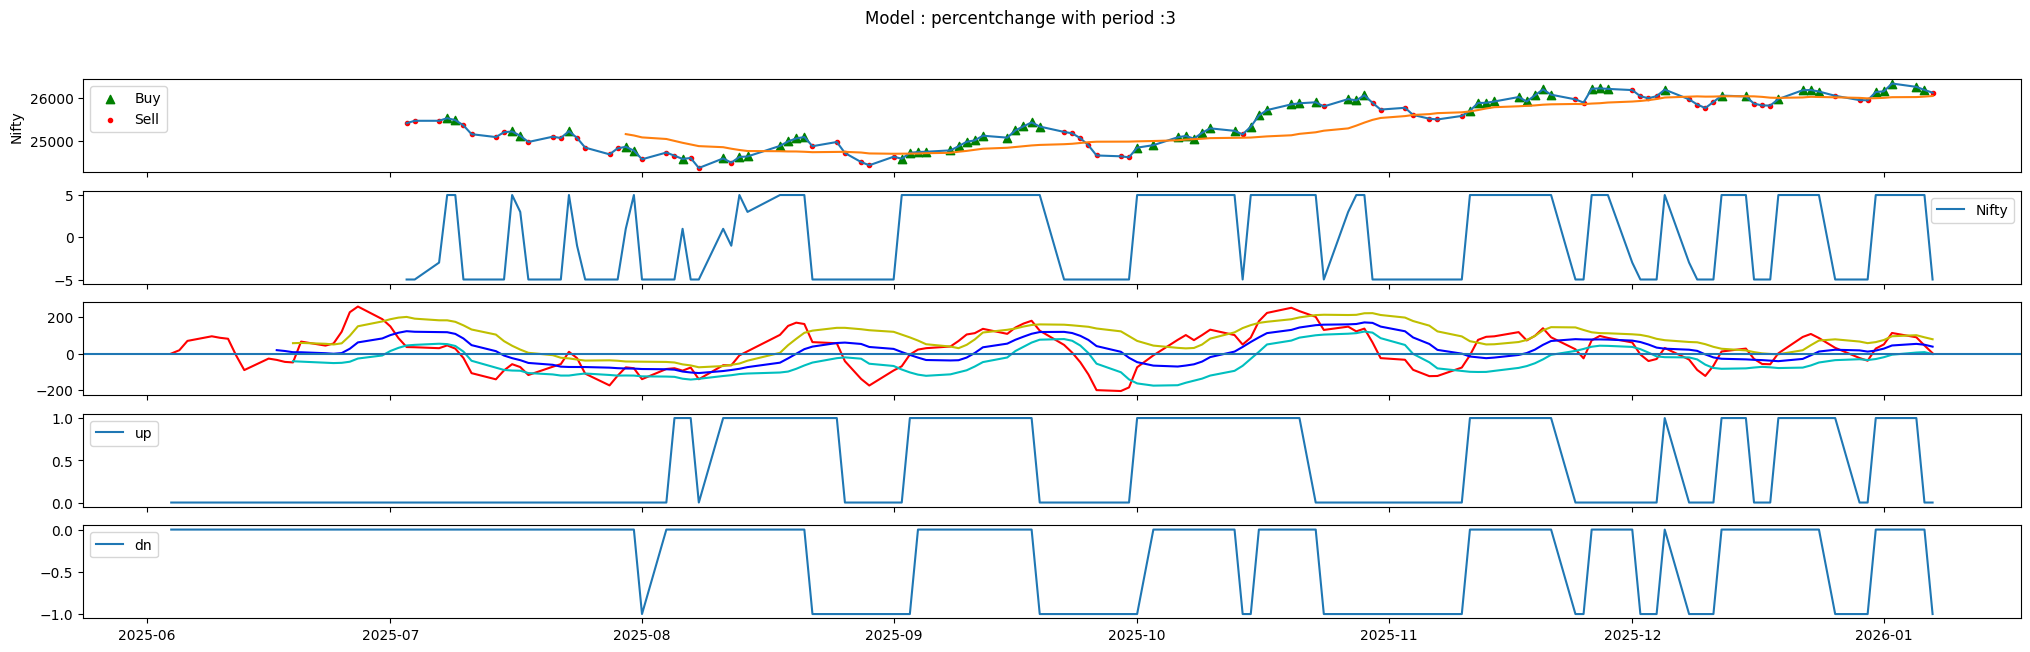

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1, figsize=(25,7),sharex=True)
ax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'Close'])
ax[0].plot(price_data_new.loc[:,:].index,price_data_new.loc[:,'Close'].rolling(window=20).mean())
ax[1].plot(price_data_new.loc[:, :].index, y_pred_new_p, label='Nifty')
ax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].Close,marker='^',label='Buy',color='g')
ax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].Close,marker='.',label='Sell',color='r')
ax[2].plot(df[['bband']][:],color='r')
ax[2].plot(df[['avg',]][:],color='b')
ax[2].plot(df[['Upper Band',]][:],color='y')
ax[2].plot(df[['Lower Band']][:],color='c')
ax[2].axhline(y=0)
ax[3].plot(df['upsignal'] , label='up')
ax[4].plot(df['dnsignal'],label='dn')
ax[0].legend(loc='upper left')
ax[3].legend(loc='upper left')
ax[4].legend(loc='upper left')
ax[0].set_ylabel('Nifty')
ax[1].legend('ML Signal')
ax[1].legend(loc='best')
fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))
plt.savefig('ml.png')
plt.show()


In [59]:
price_data_new.to_csv('result.csv')

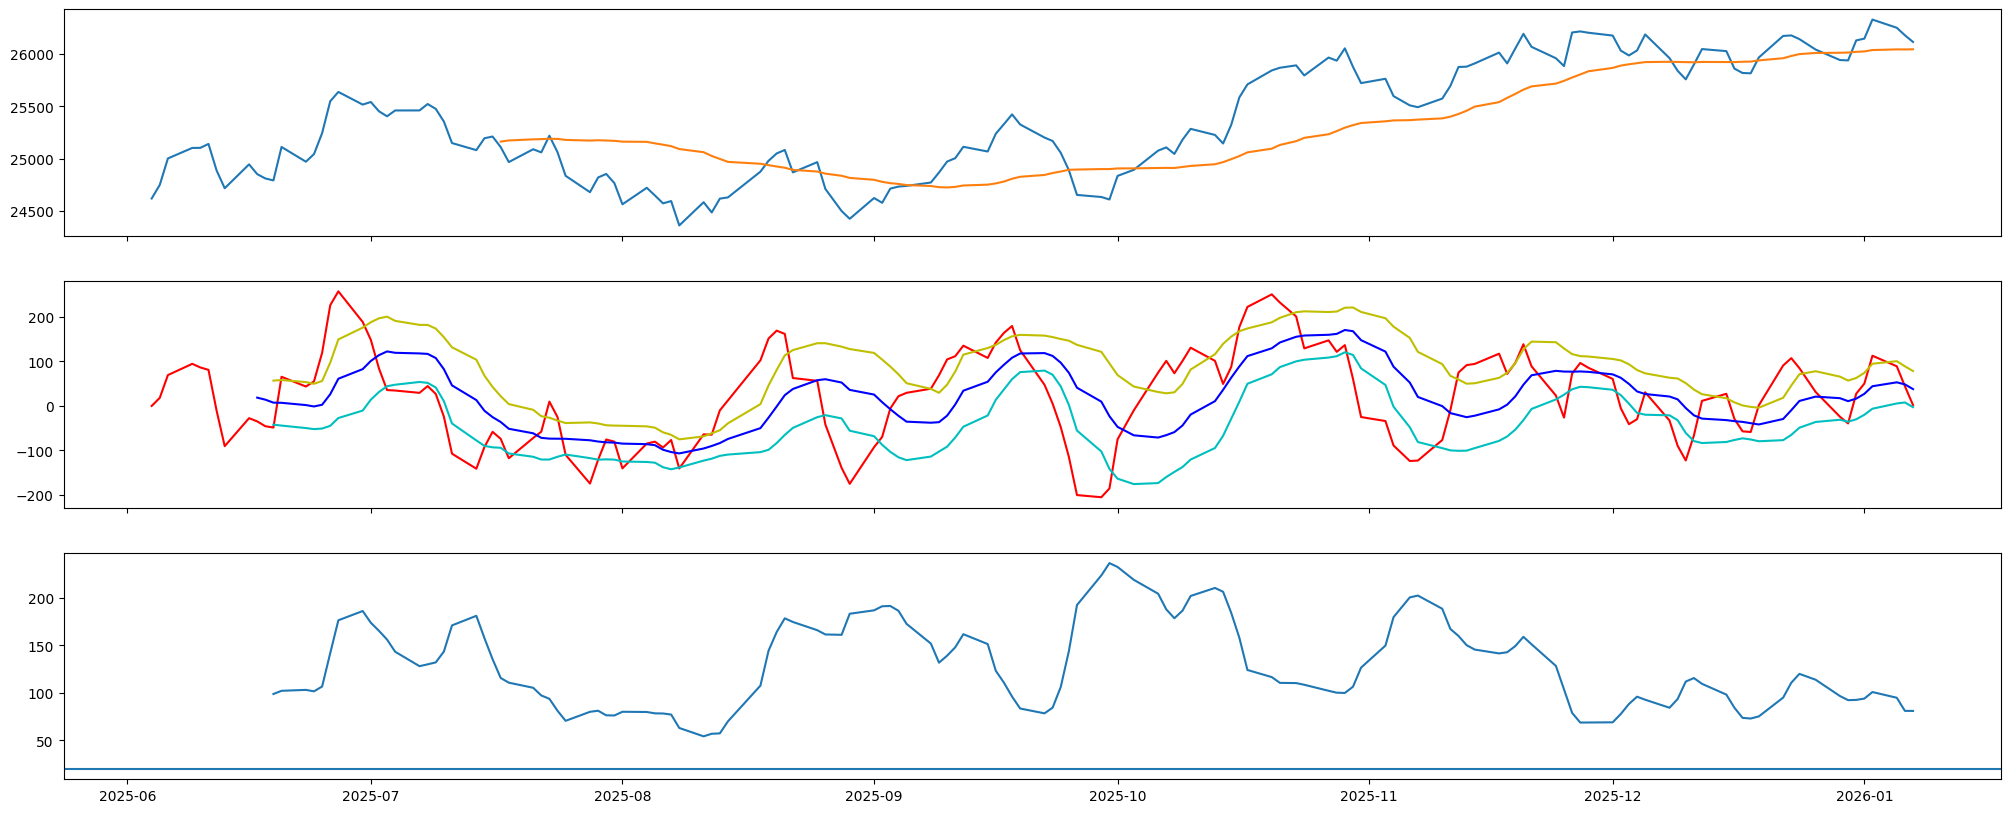

In [60]:
fig, ax = plt.subplots(3,1, figsize=(25,10),sharex=True)
ax[0].plot(df.loc[:, 'Close'])
ax[0].plot(df.loc[:,'Close'].rolling(window=32).mean())
ax[1].plot(df[['bband']][:],color='r')
ax[1].plot(df[['avg',]][:],color='b')
ax[1].plot(df[['Upper Band',]][:],color='y')
ax[1].plot(df[['Lower Band']][:],color='c')
ax[2].plot(df['Upper Band']-df['Lower Band'])
ax[2].axhline(y=20)
plt.show()

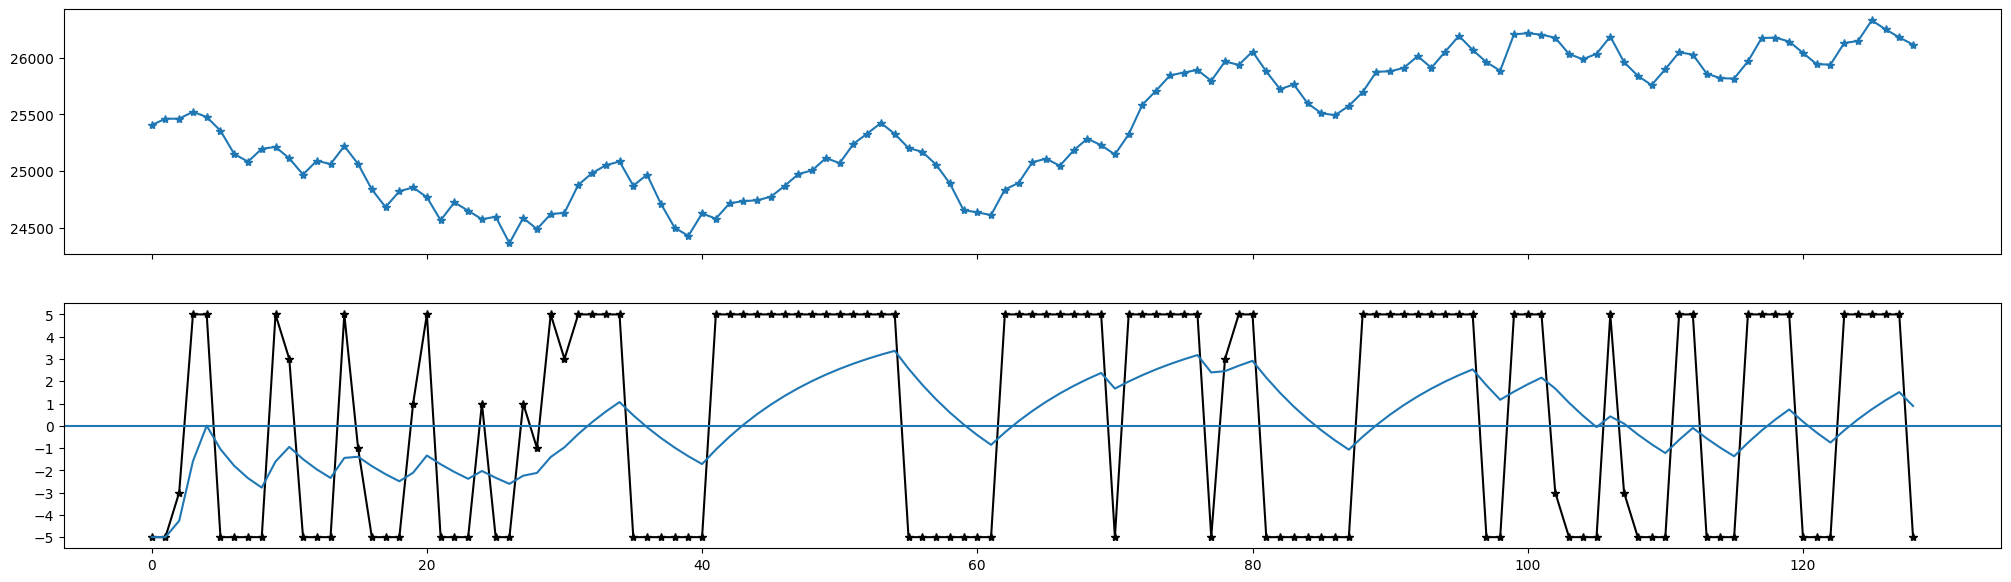

In [61]:
fig, ax = plt.subplots(2,1, figsize=(25,7),sharex=True)
ax[0].plot(pd.Series(price_data_new['Close'].values,),'*-')
rng = np.arange(-9,8,1)
ax[1].set_yticks(rng)
ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)),'k*-')
ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)).ewm(span=20).mean())
ax[1].axhline(y=0);

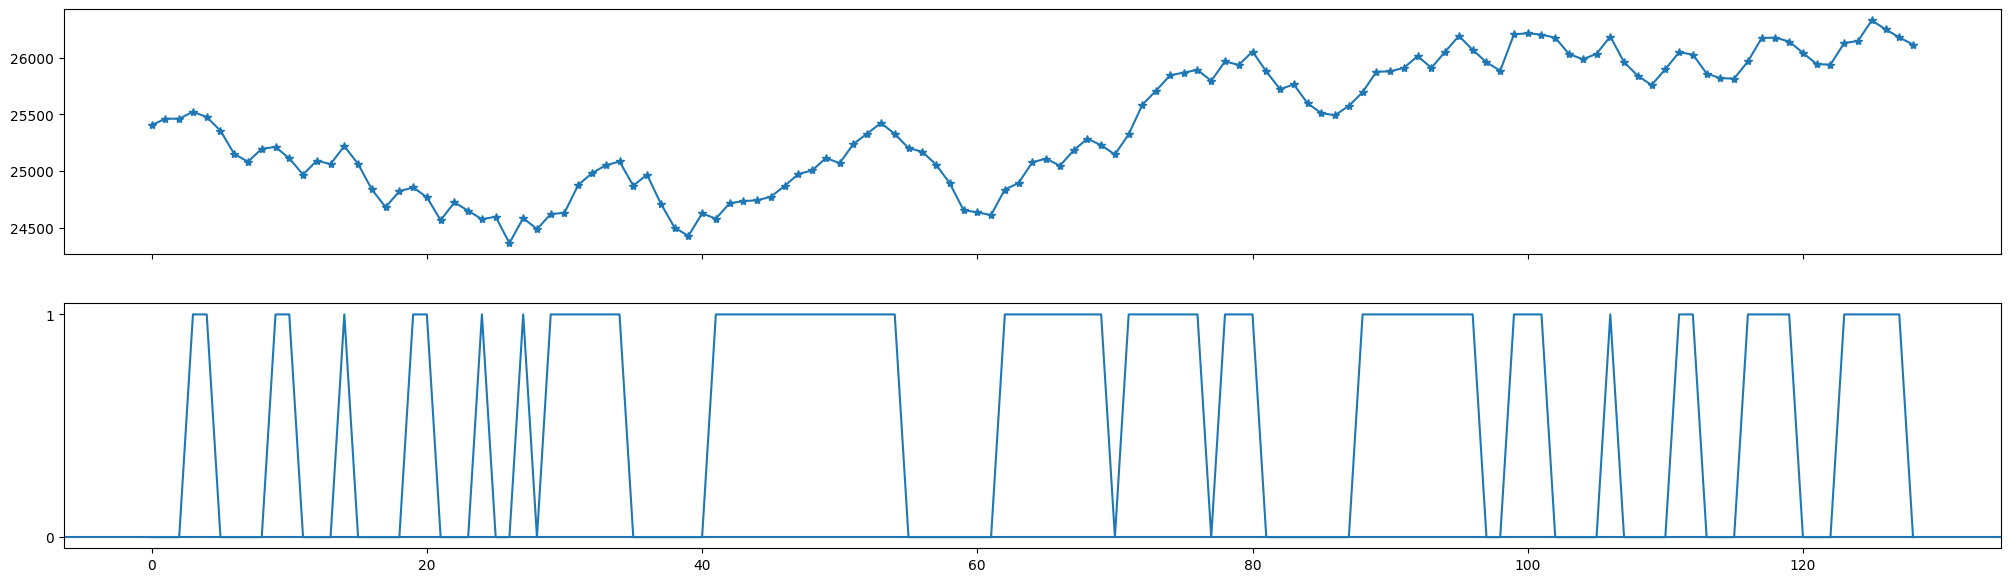

In [62]:
fig, ax = plt.subplots(2,1, figsize=(25,7),sharex=True)
ax[0].plot(pd.Series(price_data_new['Close'].values,),'*-')
rng = np.arange(-9,8,1)
ax[1].set_yticks(rng)
ax[1].plot(pd.Series(np.where(S_test_new.sum(axis=1)>0,1,0)))
#ax[1].plot(pd.Series(S_test_new[:].sum(axis=1)).ewm(span=20).mean())
ax[1].axhline(y=0);

In [63]:
price_data_new['Position']=(np.where(S_test_new.sum(axis=1)>0,1,0))
# Calculate returns based on NEXT DAY's Open price
price_data_new['Returns'] = (price_data_new['Open'].shift(-2) / price_data_new['Close'].shift(-1) - 1) * price_data_new['Position']


In [64]:
price_data_new['Open'].shift(-1).tail(5)

,Open
Date,
2026-01-01,26155.1
2026-01-02,26333.7
2026-01-05,26189.7
2026-01-06,26143.1
2026-01-07,NaN


In [65]:
price_data_new['Close'].tail(5)

,Close
Date,
2026-01-01,26146.55
2026-01-02,26328.55
2026-01-05,26250.30
2026-01-06,26178.70
2026-01-07,26114.85


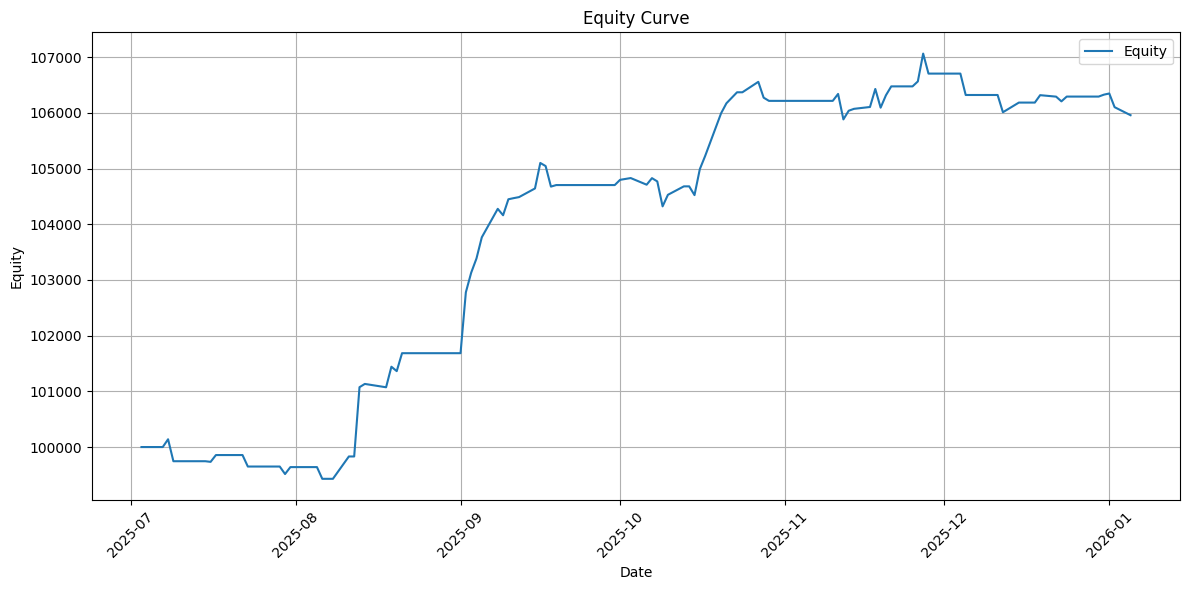

In [66]:
initial_capital = 100000
price_data_new['Equity'] = initial_capital * (1 + price_data_new['Returns']).cumprod()
# Plot the Equity Curve
plt.figure(figsize=(12, 6))  # Adjust figure size as desired
plt.plot(price_data_new.index, price_data_new['Equity'], label='Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

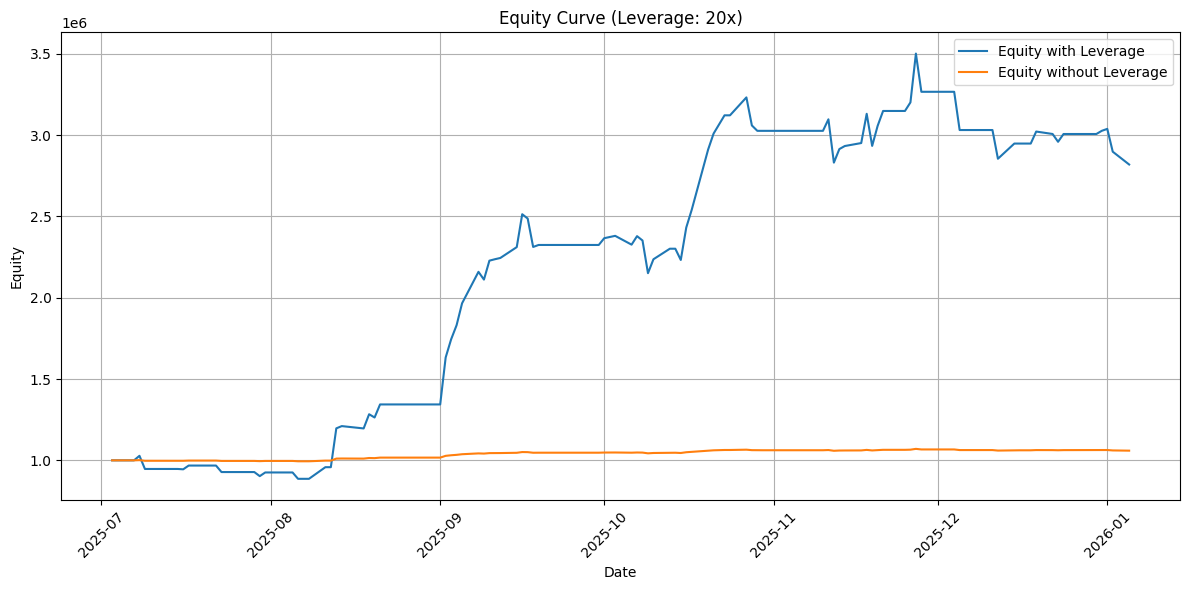

In [67]:

# Assuming price_data_new is already defined
initial_capital = 1000000
leverage = 20 # Set your desired leverage here

# Calculate leveraged returns
price_data_new['Leveraged_Returns'] = price_data_new['Returns'] * leverage

# Calculate equity with leverage
price_data_new['Equity'] = initial_capital * (1 + price_data_new['Leveraged_Returns']).cumprod()

# Calculate equity without leverage for comparison
price_data_new['Equity_No_Leverage'] = initial_capital * (1 + price_data_new['Returns']).cumprod()

# Plot the Equity Curves
plt.figure(figsize=(12, 6))
plt.plot(price_data_new.index, price_data_new['Equity'], label='Equity with Leverage')
plt.plot(price_data_new.index, price_data_new['Equity_No_Leverage'], label='Equity without Leverage')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(f'Equity Curve (Leverage: {leverage}x)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

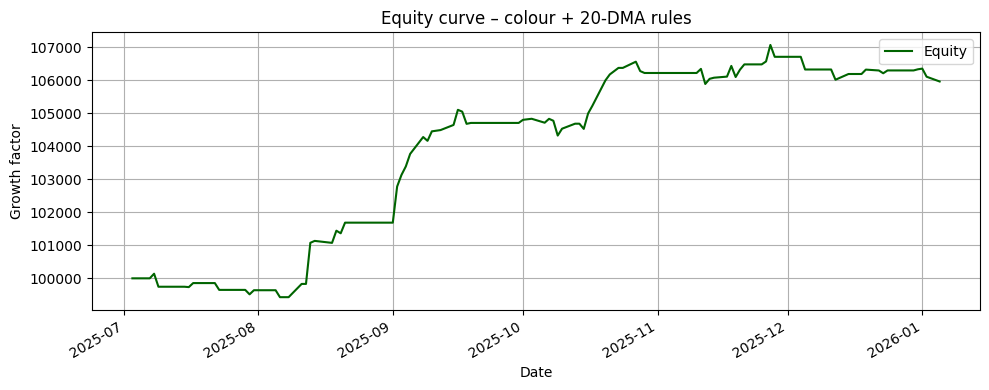

Total return nan %  |  Trades taken: 26


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = price_data_new.copy().sort_index()

# ------------------------------------------------------------------
# 0. Make Boolean Series from the raw np.where tuples
# ------------------------------------------------------------------
buy_series  = pd.Series(False, index=df.index)
sell_series = pd.Series(False, index=df.index)

buy_series.iloc[ buy[0] ]   = True          # populate True where condition met
sell_series.iloc[ sell[0] ] = True

# ------------------------------------------------------------------
# 1. 20‑day moving average
# ------------------------------------------------------------------
df['dma20'] = df['Close'].rolling(20).mean()

# ------------------------------------------------------------------
# 2. Vectorised position logic
#    +1 = long, -1 = short, 0 = flat
# ------------------------------------------------------------------
pos = pd.Series(np.nan, index=df.index)

# (1) GREEN  +  Close > 20DMA  →  long
pos.loc[  buy_series  & (df['Close'] > df['dma20']) ] =  1

# (2) RED    +  Close > 20DMA  →  short
pos.loc[  sell_series & (df['Close'] > df['dma20']) ] = -1

# (3) RED    +  Close ≤ 20DMA  →  cover (flat)
pos.loc[  sell_series & (df['Close'] <= df['dma20']) ] =  0

# Carry the last position forward on bars with no new signal
pos = pos.ffill().fillna(0)

# IMPORTANT: shift by 1 so the trade opens next day
df['position'] = pos.shift().fillna(0)


df['Returns'] = (df['Open'].shift(-2) / df['Close'].shift(-1) - 1) * df['Position']
initial_capital = 100000
equity = initial_capital * (1 + df['Returns']).cumprod()
# ------------------------------------------------------------------
# 4. Plot equity curve
# ------------------------------------------------------------------
plt.figure(figsize=(10,4))
equity.plot(label='Equity', color='darkgreen')
plt.title('Equity curve – colour + 20‑DMA rules')
plt.ylabel('Growth factor')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Total return %.2f %%  |  Trades taken: %d" %
      ((equity.iloc[-1]-1)*100, (df['position'].diff()!=0).sum()))


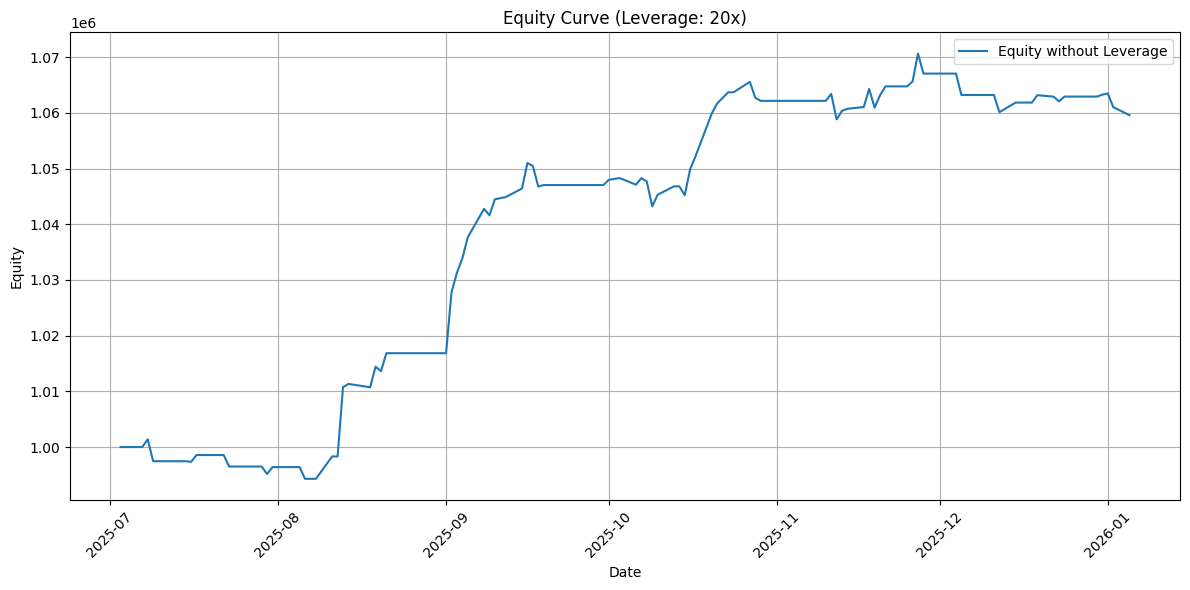

In [69]:
# Assuming price_data_new is already defined
initial_capital = 1000000
leverage = 20 # Set your desired leverage here

# Calculate leveraged returns
df['Leveraged_Returns'] = df['Returns'] * leverage

# Calculate equity with leverage
df['Equity'] = initial_capital * (1 + df['Leveraged_Returns']).cumprod()

# Calculate equity without leverage for comparison
df['Equity_No_Leverage'] = initial_capital * (1 + df['Returns']).cumprod()

# Plot the Equity Curves
plt.figure(figsize=(12, 6))
#plt.plot(df.index, df['Equity'], label='Equity with Leverage')
plt.plot(df.index, df['Equity_No_Leverage'], label='Equity without Leverage')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(f'Equity Curve (Leverage: {leverage}x)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [70]:
def calculate_metrics(returns_series, leverage=1, risk_free_rate=7.5):
    """Calculates various trade metrics with leverage.

    Args:
        returns_series (pandas.Series): A Series of daily returns.
        leverage (float): The leverage factor. Default is 1 (no leverage).
        risk_free_rate (float): The risk-free rate. Default is 0.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """

    # Apply leverage to returns
    leveraged_returns = returns_series * leverage

    # Adjust for borrowing cost (simplified)
    borrowing_cost = (leverage - 1) * risk_free_rate / 252  # Daily borrowing cost
    net_leveraged_returns = leveraged_returns - borrowing_cost

    annualized_return = (1 + net_leveraged_returns).prod() ** (252 / len(net_leveraged_returns)) - 1
    annualized_std = net_leveraged_returns.std() * np.sqrt(252)

    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std

    cumulative_returns = (1 + net_leveraged_returns).cumprod()
    cumulative_max = cumulative_returns.cummax()
    drawdowns = cumulative_returns / cumulative_max - 1
    max_drawdown = drawdowns.min()
    calmar_ratio = annualized_return / abs(max_drawdown)

    # Calculate CAGR
    start_value = 1  # Initial investment
    end_value = cumulative_returns.iloc[-1]
    num_years = len(net_leveraged_returns) / 252  # Assuming 252 trading days
    cagr = (end_value / start_value) ** (1 / num_years) - 1

    metrics = {
        'CAGR': cagr,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_std,
        'Sharpe Ratio': sharpe_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown,
        'Leverage': leverage
    }

    return metrics

# Example usage:


In [71]:
metrics = calculate_metrics(price_data_new['Returns'], leverage=4, risk_free_rate=0.06)

In [72]:
for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

CAGR: nan
Annualized Return: 0.3065
Annualized Volatility: 0.1449
Sharpe Ratio: 1.7010
Calmar Ratio: 5.2283
Max Drawdown: -0.0586
Leverage: 4.0000


In [73]:
from sklearn.metrics import classification_report
y_pred=np.sign(np.where(S_test_new.sum(axis=1)==0,1,S_test_new.sum(axis=1)))
y_true=price_data_new['Close'].transform(lambda x : np.sign(x.diff(days_out)))
y_true=y_true.dropna()
y_pred=y_pred[-len(y_true):]
print("Classification Report Averaging")
print(classification_report(y_true, y_pred))

Classification Report Averaging
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        56
         1.0       1.00      1.00      1.00        70

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



Precision

Downday (-1.0): Your model is correct about 62% of the time when predicting a downday.
Upday (1.0): Your model is very reliable, showing 92% precision in predicting updays.


Recall

Downday (-1.0): Your model identifies 83% of the actual downdays correctly.
Upday (1.0): Your model identifies 80% of the actual updays correctly.


F1-Score

Downday (-1.0): An F1-score of 0.71 indicates a decent balance between precision and recall for downdays.
Upday (1.0): A strong F1-score of 0.86 shows a good balance between precision and recall for updays.


Support: There are 12 downdays and 30 updays in the dataset.

Overall Assessment

Accuracy (0.81): The averaged model demonstrates a good overall accuracy of 81%.
Macro Average & Weighted Average: These provide a summary of the model's performance across both classes, considering the class imbalance in your dataset.

In [74]:
'''
import yfinance as yf
import time
nifty50_url = "https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv"
nifty50 = pd.read_csv(nifty50_url)
tickers = nifty50['Symbol'].apply(lambda x: x + ".NS").tolist()
# Bank Nifty Stocks
nifty_stocks = tickers
start_date = '2022-12-27'
# Download the data
for ticker in tickers:
    data = yf.download(ticker, start=start_date)
    print(data.head())
    time.sleep(2)
def calculate_percentage_above_moving_average(data,periods):


    # Calculate the moving average using ewm with min_periods set to 50
    ma = data.ewm(span=periods, min_periods=periods).mean()

    above_ma = data > ma
    percentage = (above_ma.sum(axis=1) / (50)) * 100

    return percentage

# Calculate the percentage of stocks above their 200 DMA for each day
#percentage_above_dma = calculate_percentage_above_moving_average(nifty_stocks,200,'2020-05-01')
percentage_10_dma=calculate_percentage_above_moving_average(nifty_stocks,10)
percentage_50_dma=calculate_percentage_above_moving_average(nifty_stocks,50)
# Download the Bank Nifty index data
'''

'\nimport yfinance as yf\nimport time\nnifty50_url = "https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv"\nnifty50 = pd.read_csv(nifty50_url)\ntickers = nifty50[\'Symbol\'].apply(lambda x: x + ".NS").tolist()\n# Bank Nifty Stocks\nnifty_stocks = tickers\nstart_date = \'2022-12-27\'\n# Download the data\nfor ticker in tickers:\n    data = yf.download(ticker, start=start_date)\n    print(data.head())\n    time.sleep(2)\ndef calculate_percentage_above_moving_average(data,periods):\n\n\n    # Calculate the moving average using ewm with min_periods set to 50\n    ma = data.ewm(span=periods, min_periods=periods).mean()\n\n    above_ma = data > ma\n    percentage = (above_ma.sum(axis=1) / (50)) * 100\n\n    return percentage\n\n# Calculate the percentage of stocks above their 200 DMA for each day\n#percentage_above_dma = calculate_percentage_above_moving_average(nifty_stocks,200,\'2020-05-01\')\npercentage_10_dma=calculate_percentage_above_moving_average(nifty_sto

In [75]:
#percentage_above_dma_30_ema=percentage_50_dma.rolling(window=30).mean()
#percentage_above_dma_10_ema=percentage_10_dma.rolling(window=2).mean()

In [76]:
#result=percentage_above_dma_10_ema
#result2=percentage_50_dma.rolling(window=5).mean()

In [77]:
#import matplotlib.pyplot as plt

In [78]:
# First plot: Nifty 50 Close with Buy/Sell signals
#fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

# Plot the close prices
#ax.plot(price_data_new.index, price_data_new['Close'], label='Close', color='blue')
'''
# Add Buy signals
ax.scatter(
    price_data_new.iloc[buy].index,
    price_data_new.iloc[buy]['Close'],
    marker='^',
    label='Buy',
    color='green'
)

# Add Sell signals
ax.scatter(
    price_data_new.iloc[sell].index,
    price_data_new.iloc[sell]['Close'],
    marker='v',
    label='Sell',
    color='red'
)

# Add legend and labels
ax.legend()
ax.set_title('Nifty 50 Close with Buy/Sell Signals')
ax.set_ylabel('Close Price')
ax.grid()

# Plot the moving averages on the first subplot
for window in range(5, 31):
    ax.plot(
        price_data_new.index,
        price_data_new['Close'].rolling(window=window).mean(),
        label=f'MA {window}',
        linewidth=0.8
    )




# Adjust layout and show the second plot
fig.tight_layout()
plt.show()
'''

"\n# Add Buy signals\nax.scatter(\n    price_data_new.iloc[buy].index,\n    price_data_new.iloc[buy]['Close'],\n    marker='^',\n    label='Buy',\n    color='green'\n)\n\n# Add Sell signals\nax.scatter(\n    price_data_new.iloc[sell].index,\n    price_data_new.iloc[sell]['Close'],\n    marker='v',\n    label='Sell',\n    color='red'\n)\n\n# Add legend and labels\nax.legend()\nax.set_title('Nifty 50 Close with Buy/Sell Signals')\nax.set_ylabel('Close Price')\nax.grid()\n\n# Plot the moving averages on the first subplot\nfor window in range(5, 31):\n    ax.plot(\n        price_data_new.index,\n        price_data_new['Close'].rolling(window=window).mean(),\n        label=f'MA {window}',\n        linewidth=0.8\n    )\n\n\n\n\n# Adjust layout and show the second plot\nfig.tight_layout()\nplt.show()\n"

In [79]:
'''
fig, ax = plt.subplots(4,1, figsize=(10,6),sharex=True)
ax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'Close'])
ax[3].plot(price_data_new.loc[:, :].index, y_pred_new_p, label='Nifty')
ax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].Close,marker='^',label='Buy',color='g')
ax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].Close,marker='.',label='Sell',color='r')
ax[2].plot(result2[-180:],color='r')
ax[1].plot(result[-180:],color='b')
#ax[2].plot(result[-180:] , label='up')
ax[0].legend(loc='upper left')
ax[2].axhline(y=50)
ax[2].axhline(y=25)
ax[1].axhline(y=50,color='g')
ax[1].axhline(y=25)
ax[0].set_ylabel('Nifty')
ax[3].legend('ML Signal')
ax[3].legend(loc='best')
fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))
plt.savefig('ml.png')
plt.show()
'''

"\nfig, ax = plt.subplots(4,1, figsize=(10,6),sharex=True)\nax[0].plot(price_data_new.loc[:, :].index, price_data_new.loc[:, 'Close'])\nax[3].plot(price_data_new.loc[:, :].index, y_pred_new_p, label='Nifty')\nax[0].scatter(price_data_new.iloc[buy].index,price_data_new.iloc[buy].Close,marker='^',label='Buy',color='g')\nax[0].scatter(price_data_new.iloc[sell].index,price_data_new.iloc[sell].Close,marker='.',label='Sell',color='r')\nax[2].plot(result2[-180:],color='r')\nax[1].plot(result[-180:],color='b')\n#ax[2].plot(result[-180:] , label='up')\nax[0].legend(loc='upper left')\nax[2].axhline(y=50)\nax[2].axhline(y=25)\nax[1].axhline(y=50,color='g')\nax[1].axhline(y=25)\nax[0].set_ylabel('Nifty')\nax[3].legend('ML Signal')\nax[3].legend(loc='best')\nfig.suptitle('Model : '+ trend_decider +' with period :' + str(period))\nplt.savefig('ml.png')\nplt.show()\n"

In [80]:
#nifty_data_format=nifty_data_format.tail(len(result))

In [81]:
'''fig, ax = plt.subplots(3,1, figsize=(10,6),sharex=True)
ax[0].plot(nifty_data_format.loc[:, :].index, nifty_data_format.loc[:, 'Close'])
ax[2].plot(result2,color='r')
ax[1].plot(result,color='b')
#ax[2].plot(result[-180:] , label='up')
ax[0].legend(loc='upper left')
ax[2].axhline(y=50)
ax[2].axhline(y=25)
ax[1].axhline(y=50,color='g')
ax[1].axhline(y=25)
ax[0].set_ylabel('Nifty')

fig.suptitle('Model : '+ trend_decider +' with period :' + str(period))
plt.savefig('ml.png')
plt.show()
'''

"fig, ax = plt.subplots(3,1, figsize=(10,6),sharex=True)\nax[0].plot(nifty_data_format.loc[:, :].index, nifty_data_format.loc[:, 'Close'])\nax[2].plot(result2,color='r')\nax[1].plot(result,color='b')\n#ax[2].plot(result[-180:] , label='up')\nax[0].legend(loc='upper left')\nax[2].axhline(y=50)\nax[2].axhline(y=25)\nax[1].axhline(y=50,color='g')\nax[1].axhline(y=25)\nax[0].set_ylabel('Nifty')\n\nfig.suptitle('Model : '+ trend_decider +' with period :' + str(period))\nplt.savefig('ml.png')\nplt.show()\n"